In [1]:
from core.data.data import Dataset
from core.loss.loss import TotalLoss
from core.network.smoothingnetwork import SmoothingNet
from torch.optim import Adam
from torch.utils import data
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [3]:
def train(net, epochs, batch_size, optimizer, dataset, device='cpu'):
    dataloader = data.DataLoader(dataset, batch_size=batch_size)
    net.to(device)
    net.train()
    
    criteria = TotalLoss().to(device)
    for e in range(epochs):
        print("Epoch: {}".format(e+1))
        for i, (images, binary_mask) in enumerate(dataloader):
            print("\tBatch: {}".format(i+1))
            optimizer.zero_grad()
            images = images.to(device)
            binary_mask = binary_mask.to(device)
            
            smooth_images = net(images)
            
            loss = criteria(images, smooth_images, binary_mask)
            print("\tLoss: {}".format(loss.item()))
            loss.backward()
            torch.nn.utils.clip_grad_value_(net.parameters(), 1.0)
            plot_grad_flow(net.named_parameters())
            optimizer.step()
    
    torch.save({'state_dict':net.state_dict(),
                    'epoch':e}, ('model.pth'))

In [4]:
%matplotlib inline
net = SmoothingNet()
epochs = 30
batch_size = 1
dataset = Dataset("images", "edges")
optimizer = Adam(net.parameters())


Epoch: 1
	Batch: 1
	Loss: 21.07195472717285
Epoch: 2
	Batch: 1
	Loss: nan
Epoch: 3
	Batch: 1
	Loss: nan
Epoch: 4
	Batch: 1
	Loss: nan
Epoch: 5
	Batch: 1
	Loss: nan


/Users/bryanwu/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/Users/bryanwu/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


KeyboardInterrupt: 

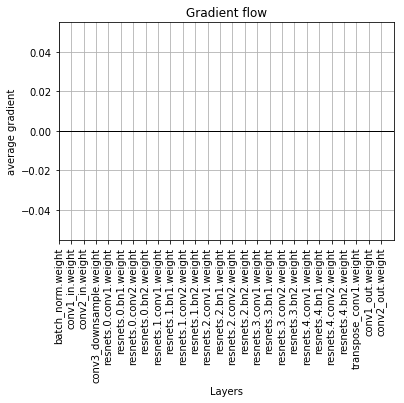

In [5]:
train(net, epochs, batch_size, optimizer, dataset)